In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import  confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

%matplotlib inline

# Title: Pima Indians Diabetes Database
The diagnostic, binary-valued variable investigated is whether the patient shows signs of diabetes according to World Health Organization criteria (i.e., if the 2 hour post-load plasma glucose was at least 200 mg/dl at any survey  examination or if found during routine medical care). The population lives near Phoenix, Arizona, USA. Results: Their ADAP algorithm makes a real-valued prediction between 0 and 1. This was transformed into a binary decision using a cutoff of 0.448. Using 576 training instances, the sensitivity and specificity of their algorithm was 76% on the remaining 192 instances. 

## Relevant Information:
Several constraints were placed on the selection of these instances from a larger database.  In particular, all patients here are females at least 21 years old of Pima Indian heritage.  ADAP is an adaptive learning routine that generates and executes digital analogs of perceptron-like devices.  It is a unique algorithm; see the paper for details.

## For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

df_meta = pd.read_csv('pima-indians-diabetes.csv',nrows=9,header=None)
df_meta

## Reading Data

In [2]:
df_columns = ['Preganancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']

In [3]:
df = pd.read_csv('pima-indians-diabetes.csv',skiprows=9,header = None)
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.columns = df_columns
df.head()

,Preganancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Checking Missing Values

In [5]:
df.isna().sum(axis=0)

Preganancies                0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
(df[:] < 0).sum(axis=0)

Preganancies                0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Age Distribution

In [7]:
df['Age'].describe()

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

In [8]:
print("Average age of Patients is {0:2.2f}".format(df['Age'].describe()['mean']) )

Average age of Patients is 33.24


In [9]:
print("Standard Deviation of age of Patients is {0:2.2f}".format(df['Age'].describe()['std']) )

Standard Deviation of age of Patients is 11.76


<AxesSubplot:xlabel='Age', ylabel='Count'>

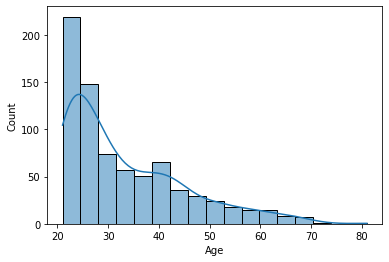

In [10]:
sns.histplot(df['Age'],kde=True)

<AxesSubplot:>

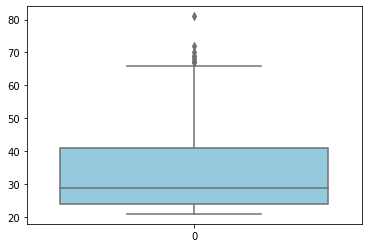

In [11]:
sns.boxplot(data = df['Age'],color='skyblue')

## Removing Outliers

In [12]:
def remove_outlier(p):
    upper = p.quantile(0.75)
    lower = p.quantile(0.25)
    iqr =upper - lower
    # df.loc[df[numeric]>=df[numeric].quantile(0.75)+iqr*1.5]
    factor=iqr*1.5
    cond = (p>=upper+factor) | (p<=lower-factor)
    p.loc[cond] = p.median()
    return p

In [13]:
df[df_columns]=df[df_columns].apply(remove_outlier)

<AxesSubplot:>

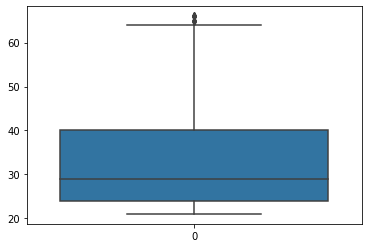

In [14]:
sns.boxplot(data = df['Age'])

## Studying Relationship of Age and BMI with Class

### mean values

In [15]:
pd.pivot_table(data=df,
               values=['BMI','Age'],
               index='Outcome',
               aggfunc=np.mean)

,Age,BMI
Outcome,,
0,30.610000,30.789000
1,36.772388,34.829478


In [16]:
## Patients that are diagnosed with diabetes tend to be 6 years older than those who are not
## Patients diagnosed with diabetes also have a Very High BMI of 35 on average

### chi2 test

In [17]:
age_outcome_ct = pd.crosstab(index = df['Outcome'],columns =df['Age'])
c, p, dof, expected = chi2_contingency(age_outcome_ct) 
print("P value between Age and Outcome is {0:2.10f}".format(p))

P value between Age and Outcome is 0.0000000001


#### we discover a significant relationship between Age and Outcome with a p-value < 0.05

In [18]:
bmi_outcome_ct = pd.crosstab(index = df['Outcome'],columns =df['BMI'])
c, p, dof, expected = chi2_contingency(bmi_outcome_ct) 
print("P value between BMI and Outcome is {0:2.10f}".format(p))

P value between BMI and Outcome is 0.0527182618


#### we discover a significant relationship between Age and Outcome with a p-value ~ 0.05

In [19]:
df[['BMI','Age','Outcome']].corr()

,BMI,Age,Outcome
BMI,1.000000,0.077668,0.300615
Age,0.077668,1.000000,0.265858
Outcome,0.300615,0.265858,1.000000


In [20]:
pd.pivot_table(data=df,
               index=['Outcome'],
               aggfunc=np.sum)

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Preganancies,SkinThickness
Outcome,,,,,,,,
0,15305,15394.5,35426,200.2020,55341,28242.5,1649,9832
1,9855,9334.3,20021,128.2465,38091,18543.5,1256,5864


## Checking if classes are balanced

Text(3.2, 10, 'No Diabetes 0.65%\n Diabetes 0.35%')

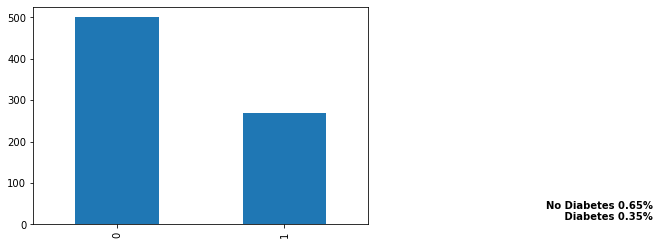

In [21]:
df['Outcome'].value_counts().plot(kind='bar')
annotation = str("No Diabetes {0:2.2f}%\n Diabetes {1:2.2f}%".format(1 - np.mean(df['Outcome']) , np.mean(df['Outcome'])))
plt.text(3+0.2,10, annotation, horizontalalignment='right', size='medium', color='black', weight='semibold')

### We observe slight skewness but not something to worry about

## Building Prediction Model

In [22]:
X = df.iloc[:,0:-1]
y = df['Outcome']
X.head()

,Preganancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0.0,33.6,0.6270,50
1,1,85,66,29,0.0,26.6,0.3510,31
2,8,183,64,0,0.0,23.3,0.6720,32
3,1,89,66,23,94.0,28.1,0.1670,21
4,0,137,40,35,168.0,43.1,0.3725,33


### Scaling Data using Min-Max Scaler

#### Min-Max Scaler was preferred over Standard Scaler because usage of standard scaler resulted in model having high accuracy but very low recall

In [23]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### Converting into numpy arrays
#### This step is not particularly needed but some libraries expect data to be in numpy array format

In [24]:
X = np.array(X)
y = np.array(y)

In [25]:
X_train , X_test , y_train , y_test = train_test_split(X,y,train_size=0.8,random_state=1)

### Playing with Parameters
#### Using all 3 solvers to observe if I can get any Better Results
#### Afterall, there is 'No Free Lunch'

In [26]:
logistic_regression_model = LogisticRegression(penalty='l2' , random_state=42 , max_iter = 10000)
logistic_regression_model2 = LogisticRegression(penalty = 'elasticnet' , l1_ratio=0.5, random_state = 42 , max_iter=10000, solver = 'saga')
logistic_regression_model3 = LogisticRegression(penalty = 'l1' , random_state = 42 , max_iter=10000, solver = 'liblinear')

In [27]:
logistic_regression_model.fit(X_train,y_train)
logistic_regression_model2.fit(X_train,y_train)
logistic_regression_model3.fit(X_train,y_train)

LogisticRegression(max_iter=10000, penalty='l1', random_state=42,
                   solver='liblinear')

### Model 1 using Ridge Regression

In [28]:
logistic_regression_model.score(X=X_test,y=y_test)

0.7662337662337663

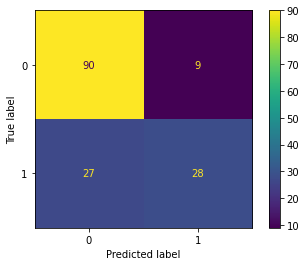

In [29]:
cm1 = confusion_matrix(y_true=y_test , y_pred=logistic_regression_model.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm1).plot()

In [30]:
print(metrics.classification_report(y_test, y_pred = logistic_regression_model.predict(X_test), labels = [0,1]))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        99
           1       0.76      0.51      0.61        55

    accuracy                           0.77       154
   macro avg       0.76      0.71      0.72       154
weighted avg       0.76      0.77      0.75       154



### Model 2 using ElasticNet Regression

In [31]:
logistic_regression_model2.score(X=X_test,y=y_test)

0.7857142857142857

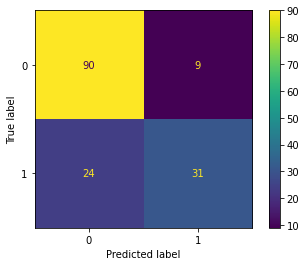

In [32]:
cm2 = confusion_matrix(y_true=y_test , y_pred=logistic_regression_model2.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()

In [33]:
print(metrics.classification_report(y_test, y_pred = logistic_regression_model2.predict(X_test), labels = [0,1]))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85        99
           1       0.78      0.56      0.65        55

    accuracy                           0.79       154
   macro avg       0.78      0.74      0.75       154
weighted avg       0.78      0.79      0.78       154



### Model 3 using Lasso Regression

In [34]:
logistic_regression_model3.score(X=X_test,y=y_test)

0.7792207792207793

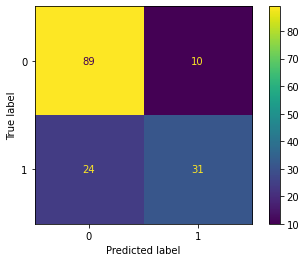

In [35]:
cm3 = confusion_matrix(y_true=y_test , y_pred=logistic_regression_model3.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm3).plot()

In [36]:
print(metrics.classification_report(y_test, y_pred = logistic_regression_model3.predict(X_test), labels = [0,1]))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        99
           1       0.76      0.56      0.65        55

    accuracy                           0.78       154
   macro avg       0.77      0.73      0.74       154
weighted avg       0.78      0.78      0.77       154



### All 3 models seem to perform fairly similarly on the dataset with equivalent accuracy , precision and recall scores

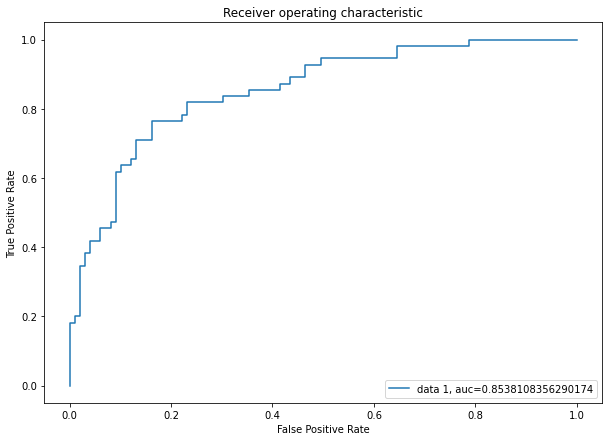

In [37]:
y_pred_proba = logistic_regression_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize = (10,7))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")